In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# 特征列
features = ['f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

# ========================
# Step 1. 定义 Autoencoder
# ========================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# ========================
# Step 2. 加载训练集 tube1~3
# ========================
train_files = ['tube1.csv', 'tube2.csv', 'tube3.csv']
train_dfs = []

for file in train_files:
    df = pd.read_csv(file)
    f7_rounded = df['f7'].round(6)
    df['label'] = (~f7_rounded.isin([0.857143, 0.714286])).astype(int)
    df = df.dropna(subset=features)
    df = df[df['label'] == 0]  # 只用正常样本训练
    train_dfs.append(df)

train_df = pd.concat(train_dfs, ignore_index=True)
X_train_raw = train_df[features].values

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# ========================
# Step 3. 训练 Autoencoder
# ========================
model = Autoencoder(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(800):
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

# 设置阈值：用训练集重构误差的 95% 分位
with torch.no_grad():
    train_reconstructed = model(X_train_tensor)
    train_mse = torch.mean((X_train_tensor - train_reconstructed)**2, dim=1).numpy()
threshold_ae = np.percentile(train_mse, 80)

# ========================
# Step 4. 测试 tube4, tube5
# ========================
test_files = ['tube4.csv', 'tube5.csv']
for file in test_files:
    print(f"\n🔍 Testing: {file}")
    df = pd.read_csv(file)
    f7_rounded = df['f7'].round(6)
    df['label'] = (~f7_rounded.isin([0.857143, 0.714286])).astype(int)
    df = df.dropna(subset=features)
    y_true = df['label'].values

    X_test_raw = df[features].values
    X_test_scaled = scaler.transform(X_test_raw)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

    # --- 1. Autoencoder ---
    with torch.no_grad():
        reconstructed = model(X_test_tensor)
        test_mse = torch.mean((X_test_tensor - reconstructed)**2, dim=1).numpy()
    ae_pred = (test_mse > threshold_ae).astype(int)

    # --- 2. LOF ---
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    lof_pred = lof.fit_predict(X_test_scaled)  # -1 = outlier
    lof_pred = (lof_pred == -1).astype(int)

    # --- 3. Isolation Forest ---
    isof = IsolationForest(contamination=0.05, random_state=42)
    isof_pred = isof.fit_predict(X_test_scaled)
    isof_pred = (isof_pred == -1).astype(int)

    # --- 融合（投票法） ---
    votes = ae_pred + lof_pred + isof_pred
    fused_pred = (votes >= 2).astype(int)

    # --- 评估 ---
    print("Classification Report (Fused Prediction):")
    print(classification_report(y_true, fused_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, fused_pred))


找到的文件: ['C:\\Users\\gao yy\\Desktop\\tube\\tube1.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube2.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube3.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube4.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube5.csv']

总样本数: 942045


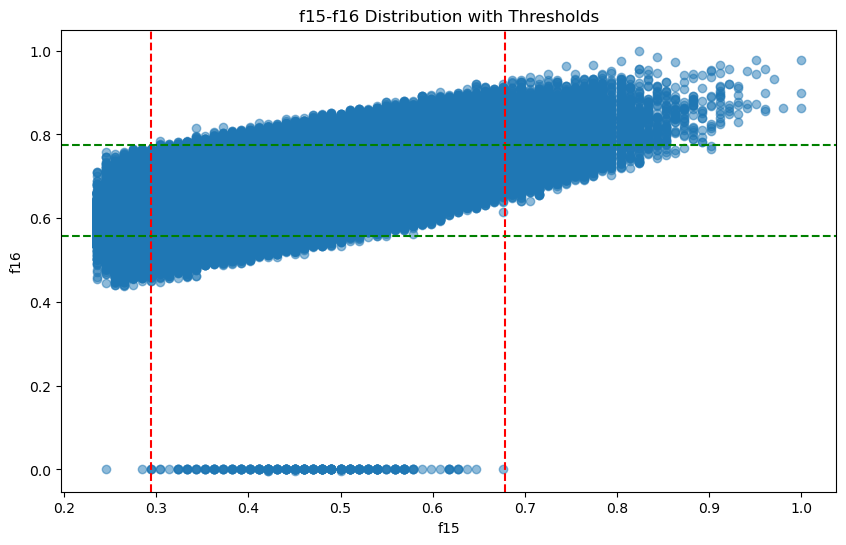


标签分布:
label
0    831171
1    110874
Name: count, dtype: int64

异常比例: 11.77%

训练集样本数: 548383 (tube1-3)
测试集样本数: 393662 (tube4-5)

训练正常样本数: 472508
Epoch 10/40, Loss: 1.056991
Epoch 20/40, Loss: 1.035678
Epoch 30/40, Loss: 1.016119
Epoch 40/40, Loss: 0.996335


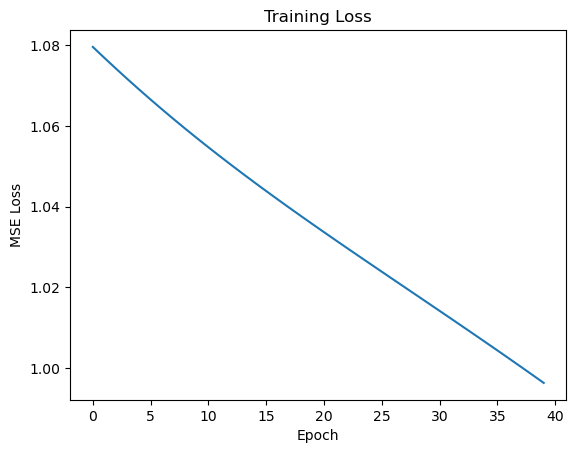


🔍 Testing tube4

分类报告:
              precision    recall  f1-score   support

           0     0.9369    0.9898    0.9627     54654
           1     0.5293    0.1463    0.2292      4266

    accuracy                         0.9288     58920
   macro avg     0.7331    0.5681    0.5959     58920
weighted avg     0.9074    0.9288    0.9096     58920


混淆矩阵:
[[54099   555]
 [ 3642   624]]


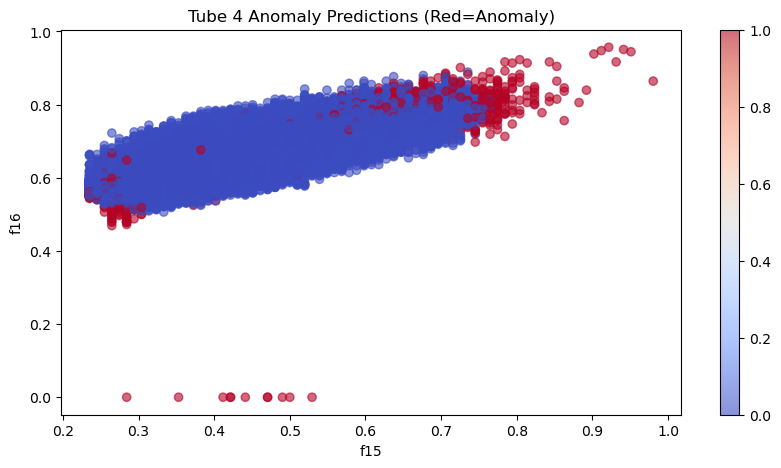


🔍 Testing tube5

分类报告:
              precision    recall  f1-score   support

           0     0.9173    0.9898    0.9522    304009
           1     0.5376    0.1171    0.1923     30733

    accuracy                         0.9097    334742
   macro avg     0.7274    0.5535    0.5722    334742
weighted avg     0.8824    0.9097    0.8824    334742


混淆矩阵:
[[300913   3096]
 [ 27134   3599]]


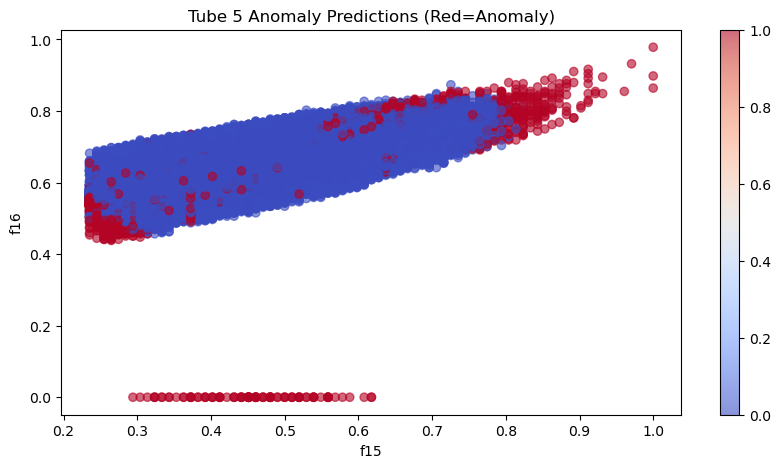

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import glob
import os
import matplotlib.pyplot as plt

# 设置特征
features = ['f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

# 1. 加载数据
file_path = r"C:\Users\gao yy\Desktop\tube\tube*.csv"
tube_files = glob.glob(file_path)
print(f"找到的文件: {tube_files}")

if not tube_files:
    raise ValueError("没有找到任何tube数据文件！请检查文件路径。")

data_list = []
for file in tube_files:
    df = pd.read_csv(file)
    tube_num = int(os.path.basename(file).replace('tube', '').replace('.csv', '')) - 1
    df['tube_id'] = tube_num
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)
print(f"\n总样本数: {len(data)}")

# 2. 根据提供的阈值定义异常
f15_lower, f15_upper = 0.294, 0.679
f16_lower, f16_upper = 0.557, 0.776

# 可视化阈值
plt.figure(figsize=(10, 6))
plt.scatter(data['f15'], data['f16'], alpha=0.5)
plt.axvline(x=f15_lower, color='r', linestyle='--')
plt.axvline(x=f15_upper, color='r', linestyle='--')
plt.axhline(y=f16_lower, color='g', linestyle='--')
plt.axhline(y=f16_upper, color='g', linestyle='--')
plt.title('f15-f16 Distribution with Thresholds')
plt.xlabel('f15')
plt.ylabel('f16')
plt.show()

# 定义异常条件 (在阈值范围外即为异常)
data['label'] = (
    (data['f15'] < f15_lower) | 
    (data['f15'] > f15_upper) | 
    (data['f16'] < f16_lower) | 
    (data['f16'] > f16_upper)
).astype(int)

print("\n标签分布:")
print(data['label'].value_counts())
print(f"\n异常比例: {data['label'].mean():.2%}")

# 3. 划分数据集
train_df = data[data['tube_id'].isin([0, 1, 2])]  # tube1-3
test_df = data[data['tube_id'].isin([3, 4])]      # tube4-5

print(f"\n训练集样本数: {len(train_df)} (tube1-3)")
print(f"测试集样本数: {len(test_df)} (tube4-5)")

# 只使用正常样本训练
train_normal = train_df[train_df['label'] == 0]
train_normal = train_normal.dropna(subset=features)

if len(train_normal) == 0:
    raise ValueError("训练集中没有正常样本！请检查阈值设置。")

print(f"\n训练正常样本数: {len(train_normal)}")

# 4. 数据标准化
X_train_raw = train_normal[features].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# 5. 定义Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. 训练模型
epochs = 40
loss_history = []

for epoch in range(epochs):
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# 绘制损失曲线
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

# 7. 测试评估
for tube_id in [3, 4]:  # tube4和tube5
    print(f"\n🔍 Testing tube{tube_id+1}")
    test_data = test_df[test_df['tube_id'] == tube_id].dropna(subset=features)
    
    if len(test_data) == 0:
        print(f"警告：tube{tube_id+1}没有可用的测试样本！")
        continue
    
    X_test = scaler.transform(test_data[features].values)
    y_true = test_data['label'].values
    
    with torch.no_grad():
        reconstructed = model(torch.tensor(X_test, dtype=torch.float32))
        mse = torch.mean((torch.tensor(X_test) - reconstructed) ** 2, dim=1).numpy()
    
    # 使用98%分位数作为阈值
    threshold = np.percentile(mse, 98)
    y_pred = (mse > threshold).astype(int)
    
    print("\n分类报告:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\n混淆矩阵:")
    print(confusion_matrix(y_true, y_pred))
    
    # 可视化预测结果
    plt.figure(figsize=(10, 5))
    plt.scatter(test_data['f15'], test_data['f16'], c=y_pred, cmap='coolwarm', alpha=0.6)
    plt.title(f'Tube {tube_id+1} Anomaly Predictions (Red=Anomaly)')
    plt.xlabel('f15')
    plt.ylabel('f16')
    plt.colorbar()
    plt.show()

找到的文件: ['C:\\Users\\gao yy\\Desktop\\tube\\tube1.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube2.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube3.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube4.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube5.csv']

总样本数: 942045


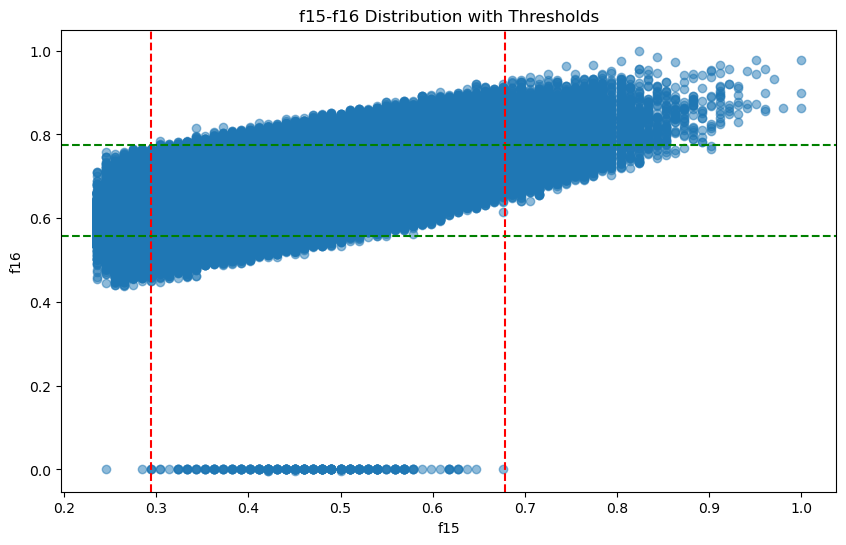


标签分布:
label
0    896778
1     45267
Name: count, dtype: int64

异常比例: 4.81%

训练集样本数: 548383 (tube1-3)
测试集样本数: 393662 (tube4-5)

训练正常样本数: 523670
Epoch 10/40, Loss: 1.027952
Epoch 20/40, Loss: 1.013642
Epoch 30/40, Loss: 0.999040
Epoch 40/40, Loss: 0.982657


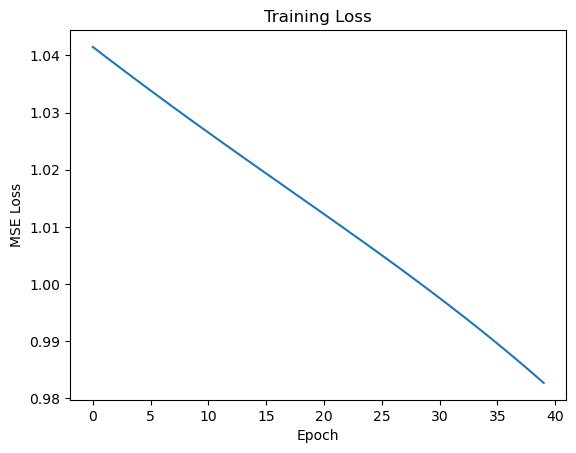


🔍 Testing tube4

分类报告:
              precision    recall  f1-score   support

           0     0.9669    0.9898    0.9782     56406
           1     0.5106    0.2395    0.3260      2514

    accuracy                         0.9578     58920
   macro avg     0.7387    0.6146    0.6521     58920
weighted avg     0.9474    0.9578    0.9504     58920


混淆矩阵:
[[55829   577]
 [ 1912   602]]


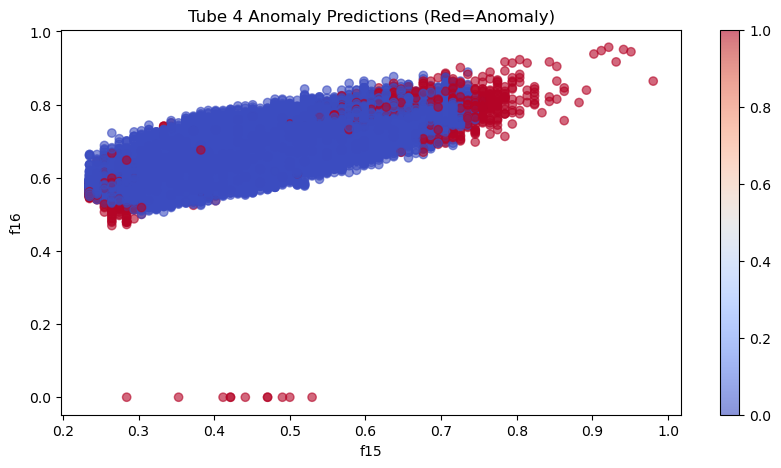


🔍 Testing tube5

分类报告:
              precision    recall  f1-score   support

           0     0.9550    0.9892    0.9718    316702
           1     0.4875    0.1809    0.2639     18040

    accuracy                         0.9456    334742
   macro avg     0.7212    0.5850    0.6178    334742
weighted avg     0.9298    0.9456    0.9336    334742


混淆矩阵:
[[313271   3431]
 [ 14776   3264]]


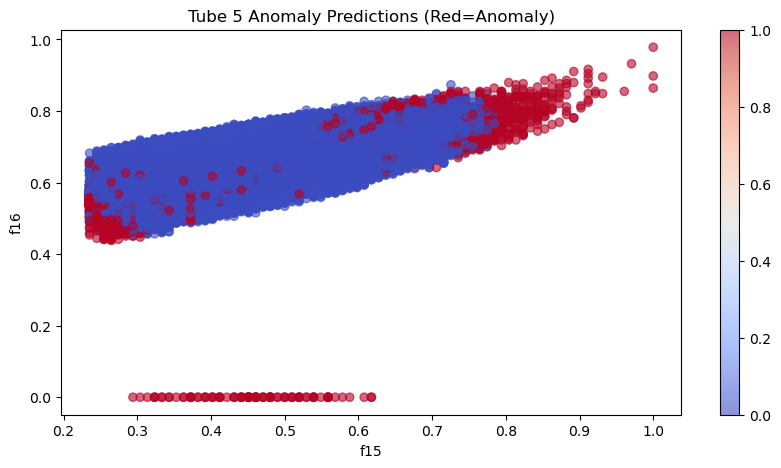

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import glob
import os
import matplotlib.pyplot as plt

# 设置特征
features = ['f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

# 1. 加载数据
file_path = r"C:\Users\gao yy\Desktop\tube\tube*.csv"
tube_files = glob.glob(file_path)
print(f"找到的文件: {tube_files}")

if not tube_files:
    raise ValueError("没有找到任何tube数据文件！请检查文件路径。")

data_list = []
for file in tube_files:
    df = pd.read_csv(file)
    tube_num = int(os.path.basename(file).replace('tube', '').replace('.csv', '')) - 1
    df['tube_id'] = tube_num
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)
print(f"\n总样本数: {len(data)}")

# 2. 根据提供的阈值定义异常
f15_lower, f15_upper = 0.294, 0.679
f16_lower, f16_upper = 0.557, 0.776

# 可视化阈值
plt.figure(figsize=(10, 6))
plt.scatter(data['f15'], data['f16'], alpha=0.5)
plt.axvline(x=f15_lower, color='r', linestyle='--')
plt.axvline(x=f15_upper, color='r', linestyle='--')
plt.axhline(y=f16_lower, color='g', linestyle='--')
plt.axhline(y=f16_upper, color='g', linestyle='--')
plt.title('f15-f16 Distribution with Thresholds')
plt.xlabel('f15')
plt.ylabel('f16')
plt.show()

# 定义异常条件 (在阈值范围外即为异常)
data['label'] = (
    (data['f15'] < f15_lower) | 
    (data['f15'] > f15_upper)).astype(int)

print("\n标签分布:")
print(data['label'].value_counts())
print(f"\n异常比例: {data['label'].mean():.2%}")

# 3. 划分数据集
train_df = data[data['tube_id'].isin([0, 1, 2])]  # tube1-3
test_df = data[data['tube_id'].isin([3, 4])]      # tube4-5

print(f"\n训练集样本数: {len(train_df)} (tube1-3)")
print(f"测试集样本数: {len(test_df)} (tube4-5)")

# 只使用正常样本训练
train_normal = train_df[train_df['label'] == 0]
train_normal = train_normal.dropna(subset=features)

if len(train_normal) == 0:
    raise ValueError("训练集中没有正常样本！请检查阈值设置。")

print(f"\n训练正常样本数: {len(train_normal)}")

# 4. 数据标准化
X_train_raw = train_normal[features].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# 5. 定义Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. 训练模型
epochs = 40
loss_history = []

for epoch in range(epochs):
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# 绘制损失曲线
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

# 7. 测试评估
for tube_id in [3, 4]:  # tube4和tube5
    print(f"\n🔍 Testing tube{tube_id+1}")
    test_data = test_df[test_df['tube_id'] == tube_id].dropna(subset=features)
    
    if len(test_data) == 0:
        print(f"警告：tube{tube_id+1}没有可用的测试样本！")
        continue
    
    X_test = scaler.transform(test_data[features].values)
    y_true = test_data['label'].values
    
    with torch.no_grad():
        reconstructed = model(torch.tensor(X_test, dtype=torch.float32))
        mse = torch.mean((torch.tensor(X_test) - reconstructed) ** 2, dim=1).numpy()
    
    # 使用98%分位数作为阈值
    threshold = np.percentile(mse, 98)
    y_pred = (mse > threshold).astype(int)
    
    print("\n分类报告:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\n混淆矩阵:")
    print(confusion_matrix(y_true, y_pred))
    
    # 可视化预测结果
    plt.figure(figsize=(10, 5))
    plt.scatter(test_data['f15'], test_data['f16'], c=y_pred, cmap='coolwarm', alpha=0.6)
    plt.title(f'Tube {tube_id+1} Anomaly Predictions (Red=Anomaly)')
    plt.xlabel('f15')
    plt.ylabel('f16')
    plt.colorbar()
    plt.show()

找到的文件: ['C:\\Users\\gao yy\\Desktop\\tube\\tube1.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube2.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube3.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube4.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube5.csv']

总样本数: 942045


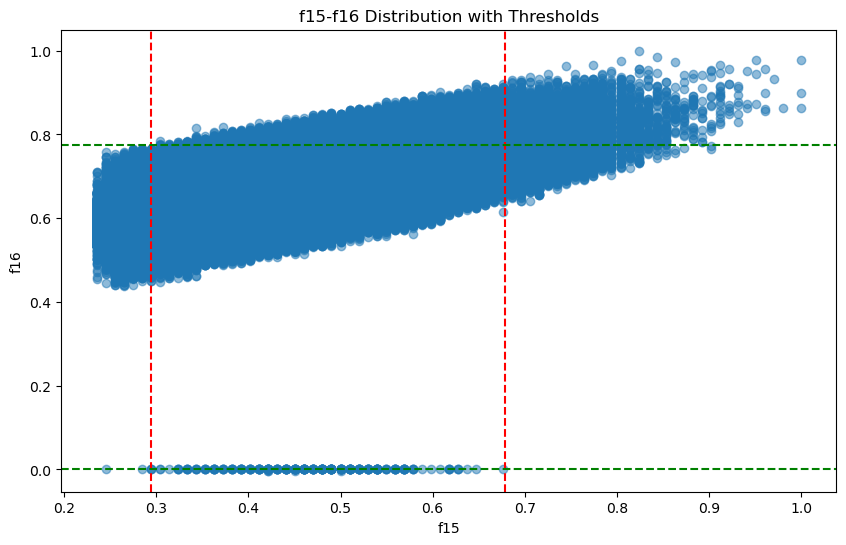


标签分布:
label
0    883624
1     58421
Name: count, dtype: int64

异常比例: 6.20%

训练集样本数: 548383 (tube1-3)
测试集样本数: 393662 (tube4-5)

训练正常样本数: 494167
Epoch 10/40, Loss: 1.025138
Epoch 20/40, Loss: 1.013843
Epoch 30/40, Loss: 1.002644
Epoch 40/40, Loss: 0.989513


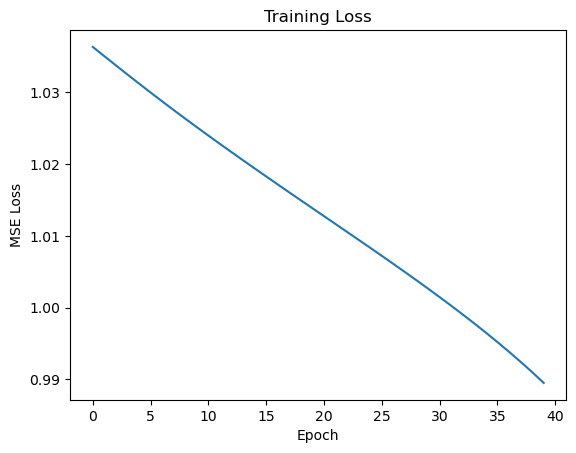


🔍 Testing tube4

分类报告:
              precision    recall  f1-score   support

           0     0.9729    0.9848    0.9789     57044
           1     0.2663    0.1674    0.2056      1876

    accuracy                         0.9588     58920
   macro avg     0.6196    0.5761    0.5922     58920
weighted avg     0.9504    0.9588    0.9542     58920


混淆矩阵:
[[56179   865]
 [ 1562   314]]


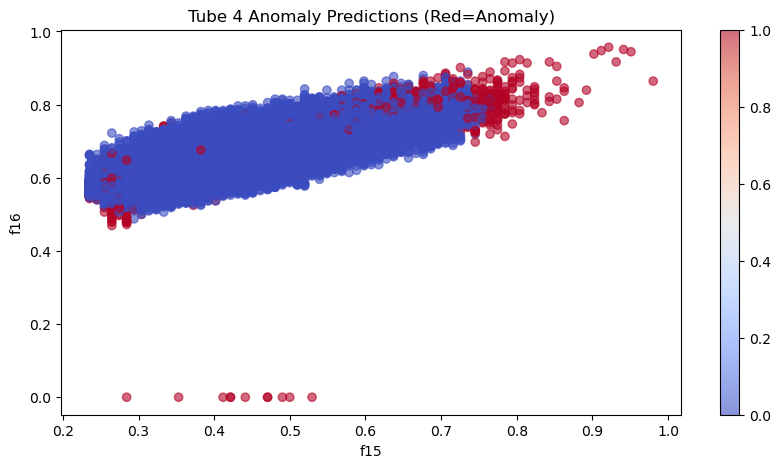


🔍 Testing tube5

分类报告:
              precision    recall  f1-score   support

           0     0.9951    0.9820    0.9885    332413
           1     0.1084    0.3117    0.1609      2329

    accuracy                         0.9774    334742
   macro avg     0.5518    0.6469    0.5747    334742
weighted avg     0.9889    0.9774    0.9828    334742


混淆矩阵:
[[326444   5969]
 [  1603    726]]


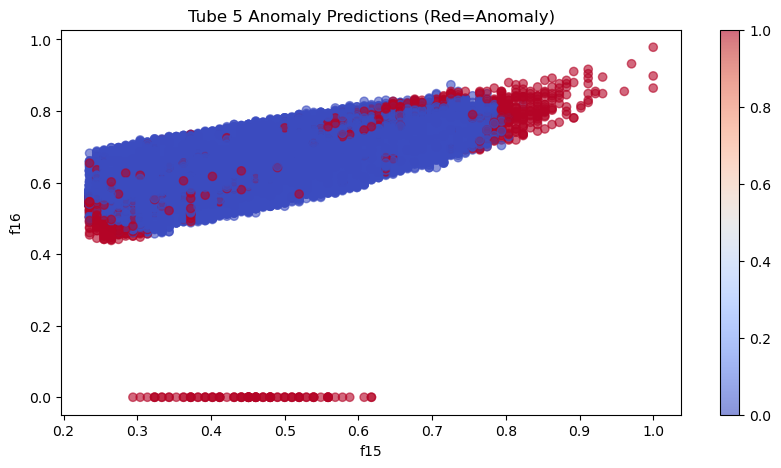

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import glob
import os
import matplotlib.pyplot as plt

# 设置特征
features = ['f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

# 1. 加载数据
file_path = r"C:\Users\gao yy\Desktop\tube\tube*.csv"
tube_files = glob.glob(file_path)
print(f"找到的文件: {tube_files}")

if not tube_files:
    raise ValueError("没有找到任何tube数据文件！请检查文件路径。")

data_list = []
for file in tube_files:
    df = pd.read_csv(file)
    tube_num = int(os.path.basename(file).replace('tube', '').replace('.csv', '')) - 1
    df['tube_id'] = tube_num
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)
print(f"\n总样本数: {len(data)}")

# 2. 根据提供的阈值定义异常
f15_lower, f15_upper = 0.294, 0.679
f16_lower, f16_upper = 0, 0.776

# 可视化阈值
plt.figure(figsize=(10, 6))
plt.scatter(data['f15'], data['f16'], alpha=0.5)
plt.axvline(x=f15_lower, color='r', linestyle='--')
plt.axvline(x=f15_upper, color='r', linestyle='--')
plt.axhline(y=f16_lower, color='g', linestyle='--')
plt.axhline(y=f16_upper, color='g', linestyle='--')
plt.title('f15-f16 Distribution with Thresholds')
plt.xlabel('f15')
plt.ylabel('f16')
plt.show()

# 定义异常条件 (在阈值范围外即为异常)
data['label'] = ( 
    (data['f16'] < f16_lower) | 
    (data['f16'] > f16_upper)
).astype(int)

print("\n标签分布:")
print(data['label'].value_counts())
print(f"\n异常比例: {data['label'].mean():.2%}")

# 3. 划分数据集
train_df = data[data['tube_id'].isin([0, 1, 2])]  # tube1-3
test_df = data[data['tube_id'].isin([3, 4])]      # tube4-5

print(f"\n训练集样本数: {len(train_df)} (tube1-3)")
print(f"测试集样本数: {len(test_df)} (tube4-5)")

# 只使用正常样本训练
train_normal = train_df[train_df['label'] == 0]
train_normal = train_normal.dropna(subset=features)

if len(train_normal) == 0:
    raise ValueError("训练集中没有正常样本！请检查阈值设置。")

print(f"\n训练正常样本数: {len(train_normal)}")

# 4. 数据标准化
X_train_raw = train_normal[features].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# 5. 定义Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 6. 训练模型
epochs = 40
loss_history = []

for epoch in range(epochs):
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# 绘制损失曲线
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

# 7. 测试评估
for tube_id in [3, 4]:  # tube4和tube5
    print(f"\n🔍 Testing tube{tube_id+1}")
    test_data = test_df[test_df['tube_id'] == tube_id].dropna(subset=features)
    
    if len(test_data) == 0:
        print(f"警告：tube{tube_id+1}没有可用的测试样本！")
        continue
    
    X_test = scaler.transform(test_data[features].values)
    y_true = test_data['label'].values
    
    with torch.no_grad():
        reconstructed = model(torch.tensor(X_test, dtype=torch.float32))
        mse = torch.mean((torch.tensor(X_test) - reconstructed) ** 2, dim=1).numpy()
    
    # 使用98%分位数作为阈值
    threshold = np.percentile(mse, 98)
    y_pred = (mse > threshold).astype(int)
    
    print("\n分类报告:")
    print(classification_report(y_true, y_pred, digits=4))
    print("\n混淆矩阵:")
    print(confusion_matrix(y_true, y_pred))
    
    # 可视化预测结果
    plt.figure(figsize=(10, 5))
    plt.scatter(test_data['f15'], test_data['f16'], c=y_pred, cmap='coolwarm', alpha=0.6)
    plt.title(f'Tube {tube_id+1} Anomaly Predictions (Red=Anomaly)')
    plt.xlabel('f15')
    plt.ylabel('f16')
    plt.colorbar()
    plt.show()

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import glob
import os

# 特征列
features = ['f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16']

# ========================
# Step 1. 定义 Autoencoder
# ========================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# ========================
# Step 2. 加载数据并定义异常
# ========================
# 定义阈值
f15_lower, f15_upper = 0.294, 0.679
f16_lower, f16_upper = 0.557, 0.776

# 使用glob加载所有tube数据
file_path = r"C:\Users\gao yy\Desktop\tube\tube*.csv"
tube_files = glob.glob(file_path)
print(f"找到的文件: {tube_files}")

if not tube_files:
    raise ValueError("没有找到任何tube数据文件！请检查文件路径。")

data_list = []
for file in tube_files:
    df = pd.read_csv(file)
    # 从文件名提取tube编号 (tube1.csv -> 0, tube2.csv -> 1, ...)
    tube_num = int(os.path.basename(file).replace('tube', '').replace('.csv', '')) - 1
    df['tube_id'] = tube_num
    data_list.append(df)

data = pd.concat(data_list, ignore_index=True)
print(f"\n总样本数: {len(data)}")

# 定义异常 (在阈值范围外即为异常)
data['label'] = (
    (data['f15'] < f15_lower) | 
    (data['f15'] > f15_upper) | 
    (data['f16'] < f16_lower) | 
    (data['f16'] > f16_upper)
).astype(int)

print("\n标签分布:")
print(data['label'].value_counts())
print(f"\n异常比例: {data['label'].mean():.2%}")

# ========================
# Step 3. 准备训练数据 (tube1-3的正常样本)
# ========================
train_df = data[data['tube_id'].isin([0, 1, 2])]  # tube1-3
train_normal = train_df[train_df['label'] == 0]  # 只使用正常样本
train_normal = train_normal.dropna(subset=features)

if len(train_normal) == 0:
    raise ValueError("训练集中没有正常样本！请检查阈值设置。")

print(f"\n训练正常样本数: {len(train_normal)}")

# 标准化
X_train_raw = train_normal[features].values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)

# ========================
# Step 4. 训练 Autoencoder
# ========================
model = Autoencoder(input_dim=X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("\n开始训练Autoencoder...")
for epoch in range(800):
    output = model(X_train_tensor)
    loss = criterion(output, X_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

# 设置阈值：用训练集重构误差的 95% 分位
with torch.no_grad():
    train_reconstructed = model(X_train_tensor)
    train_mse = torch.mean((X_train_tensor - train_reconstructed)**2, dim=1).numpy()
threshold_ae = np.percentile(train_mse, 95)
print(f"\nAutoencoder阈值(95%分位): {threshold_ae:.4f}")

# ========================
# Step 5. 测试评估 (tube4-5)
# ========================
test_df = data[data['tube_id'].isin([3, 4])]  # tube4-5

for tube_id in [3, 4]:
    print(f"\n🔍 Testing tube{tube_id+1}")
    test_data = test_df[test_df['tube_id'] == tube_id].dropna(subset=features)
    
    if len(test_data) == 0:
        print(f"警告：tube{tube_id+1}没有可用的测试样本！")
        continue
    
    X_test = scaler.transform(test_data[features].values)
    y_true = test_data['label'].values

    # --- 1. Autoencoder ---
    with torch.no_grad():
        reconstructed = model(torch.tensor(X_test, dtype=torch.float32))
        test_mse = torch.mean((torch.tensor(X_test) - reconstructed)**2, dim=1).numpy()
    ae_pred = (test_mse > threshold_ae).astype(int)

    # --- 2. LOF ---
    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
    lof_pred = lof.fit_predict(X_test)  # -1 = outlier
    lof_pred = (lof_pred == -1).astype(int)

    # --- 3. Isolation Forest ---
    isof = IsolationForest(contamination='auto', random_state=42)
    isof_pred = isof.fit_predict(X_test)
    isof_pred = (isof_pred == -1).astype(int)

    # --- 融合（投票法） ---
    votes = ae_pred + lof_pred + isof_pred
    fused_pred = (votes >= 2).astype(int)  # 至少两种方法认为是异常

    # --- 评估 ---
    print("\nClassification Report (Fused Prediction):")
    print(classification_report(y_true, fused_pred, digits=4))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, fused_pred))
    
    # 各方法结果对比
    print("\n各方法检测结果对比:")
    print(f"Autoencoder检测异常数: {sum(ae_pred)}")
    print(f"LOF检测异常数: {sum(lof_pred)}")
    print(f"Isolation Forest检测异常数: {sum(isof_pred)}")
    print(f"融合后检测异常数: {sum(fused_pred)}")

找到的文件: ['C:\\Users\\gao yy\\Desktop\\tube\\tube1.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube2.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube3.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube4.csv', 'C:\\Users\\gao yy\\Desktop\\tube\\tube5.csv']

总样本数: 942045

标签分布:
label
0    831171
1    110874
Name: count, dtype: int64

异常比例: 11.77%

训练正常样本数: 472508

开始训练Autoencoder...
Epoch 100, Loss: 0.846373
Epoch 200, Loss: 0.516750
Epoch 300, Loss: 0.351669
Epoch 400, Loss: 0.294517
Epoch 500, Loss: 0.259980
Epoch 600, Loss: 0.245363
Epoch 700, Loss: 0.235740
Epoch 800, Loss: 0.227270

Autoencoder阈值(95%分位): 0.5883

🔍 Testing tube4

Classification Report (Fused Prediction):
              precision    recall  f1-score   support

           0     0.9368    0.9783    0.9571     54654
           1     0.3561    0.1540    0.2150      4266

    accuracy                         0.9186     58920
   macro avg     0.6464    0.5661    0.5860     58920
weighted avg     0.8947    0.9186    0.9033     58920


Con